<a href="https://colab.research.google.com/github/a25/Siamese_network/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [49]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0


In [69]:
# cretate pair of positive pairs(1) and negative pairs(0)
def create_pairs(images,labels):
  digit_indices=[np.where(labels==i)[0] for i in range(10)]
  n=min([len(digit_indices[i]) for i in range(10)])-1
  pairs,ys,pair_indexes=[],[],[]
  for class_index in range(10):
    for j in range(n):
      z1_index,z2_index= digit_indices[class_index][j],digit_indices[class_index][j+1]
      pairs+=[[images[z1_index],images[z2_index]]]
      pair_indexes+=[[labels[z1_index],labels[z2_index]]]
      rand=random.randrange(1,10)
      dn=(class_index+rand)%10
      z1_index,z2_index= digit_indices[class_index][j],digit_indices[dn][j]
      pairs+=[[images[z1_index],images[z2_index]]]
      pair_indexes+=[[labels[z1_index],labels[z2_index]]]
      ys+=[1,0]
  return np.array(pairs),np.array(ys).astype('float32'),pair_indexes

In [70]:
train_x,train_y,pair_indexes=create_pairs(train_images,train_labels)
test_x,test_y,pair_indexes_test=create_pairs(test_images,test_labels)

In [71]:
train_y[:3]

array([1., 0., 1.], dtype=float32)

In [72]:
def show_image(image):
  plt.figure()
  plt.imshow(image,cmap='gray')
  plt.xticks(ticks=None)
  plt.yticks(ticks=None)
  plt.show()

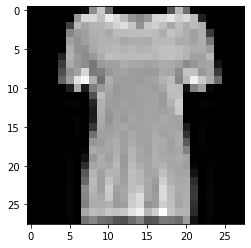

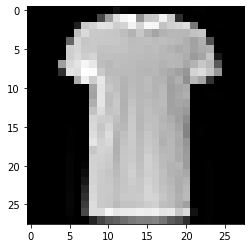

In [73]:
index=6
show_image(train_x[index][0])
show_image(train_x[index][1])

In [74]:
a=np.array([[1,2],[3,4]])
b=np.array([[5,6],[7,8]])

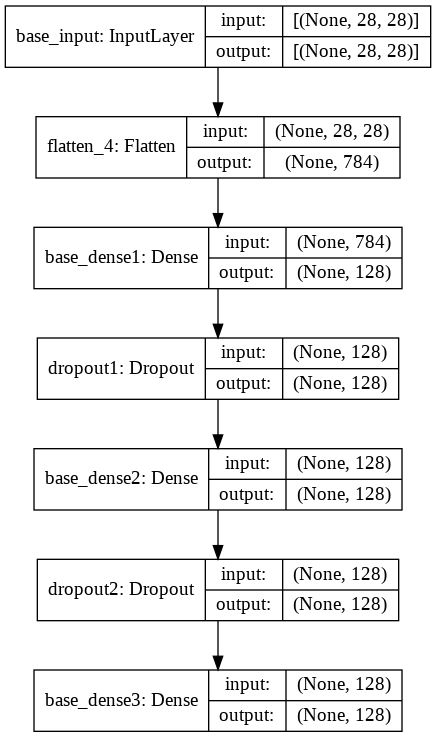

In [75]:
def initialize_base_network():
  base_input=Input(name='base_input',shape=(28,28,))
  f1=Flatten()(base_input)
  base_dense1=Dense(128,name='base_dense1',activation='relu')(f1)
  base_dropout1=Dropout(0.1,name='dropout1')(base_dense1)
  base_dense2=Dense(128,name='base_dense2',activation='relu')(base_dropout1)
  base_dropout2=Dropout(0.1,name='dropout2')(base_dense2)
  base_dense3=Dense(128,name='base_dense3',activation='relu')(base_dropout2)
  return Model(inputs=base_input,outputs=base_dense3,name='base_model')
base_network=initialize_base_network()
tf.keras.utils.plot_model(base_network,show_shapes=True,show_layer_names=True)


In [76]:
def calcualate_euclidean_distance(a):
  vec1,vec2=a
  dist=K.sqrt(K.maximum(K.sum(K.square(vec1-vec2),axis=-1,keepdims=True),K.epsilon()))
  return dist
def calc_output(shapes):
  shape1,shape2=shapes
  return (shapes1.shape[0],1)


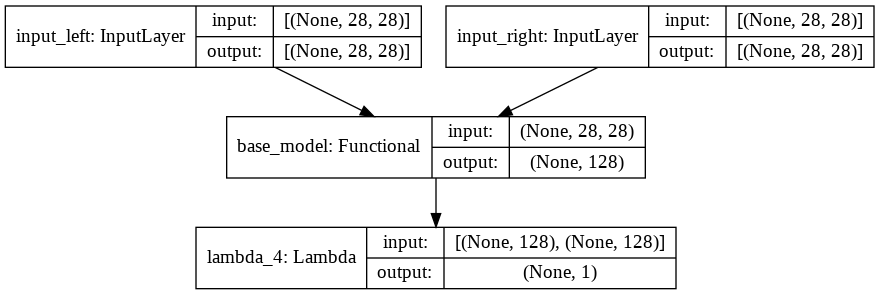

In [77]:
input_a=Input(shape=(28,28,),name='input_left')
vec_output_a=base_network(input_a)
input_b=Input(shape=(28,28,),name="input_right")
vec_output_b=base_network(input_b)
output=Lambda(calcualate_euclidean_distance,output_shape=calc_output )([vec_output_a,vec_output_b])
siamese=Model(inputs=[input_a,input_b],outputs=output)
plot_model(siamese,show_shapes=True,show_layer_names=True)


In [78]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true,y_pred):
    squared_pred=K.square(y_pred)
    margin_square=K.square(K.maximum(margin-y_pred,0))
    return K.mean(y_true*squared_pred+(1-y_true)*margin_square)
  return contrastive_loss

In [83]:
siamese.compile(loss=contrastive_loss_with_margin(margin=1),optimizer=RMSprop())

In [ ]:
history=siamese.fit([train_x[:,0],train_x[:,1]],train_y,validation_data=([test_x[:,0],test_x[:,1]],test_y),epochs=100,batch_size=500 )

In [87]:
def compute_accuracy(y,y_pred):
  pred=y_pred.ravel()>0.5
  return np.mean(pred==y)

In [91]:
preds=siamese.predict([train_x[:,0],train_x[:,1]])

In [92]:
preds

array([[0.07798976],
       [0.61168766],
       [0.03547269],
       ...,
       [1.369387  ],
       [0.00163472],
       [1.6225026 ]], dtype=float32)

In [89]:
compute_accuracy(train_y,)

0.015910985164194032

In [93]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [126]:
ids2dis=np.random.choice(len(preds),10)
pred1=preds[ids2dis]

In [115]:
left=train_x[:,0][ids2dis]
left=left.swapaxes(0,1)
left=left.reshape(left.shape[0],-1)
left.shape

In [124]:
right=train_x[:,1][ids2dis]
right=right.swapaxes(0,1)
right=right.reshape(right.shape[0],-1)
right.shape

(28, 280)

In [136]:
pred1=pred1.squeeze()
pred1 > 0.5

array([ True,  True,  True,  True, False,  True, False, False, False,
       False])

In [137]:
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

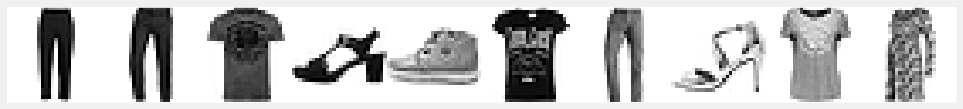

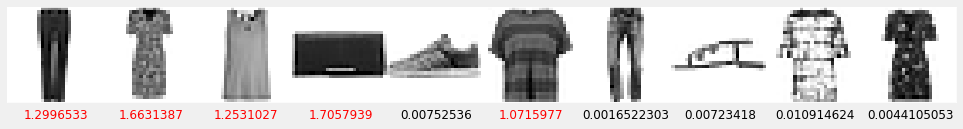

In [140]:
plt.figure(figsize=(17,3))
plt.yticks([])
plt.xticks([])
plt.imshow(left)
plt.figure(figsize=(17,3))
plt.yticks([])
plt.xticks([28*x+14 for x in range(10)],pred1)
for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if pred1[i] > 0.5: t.set_color('red') # bad predictions in red
plt.grid(None)
plt.imshow(right)